In [8]:
import tensorflow as tf
import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tensorflow import keras
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Check for TensorFlow GPU access
print(tf.config.list_physical_devices())

# See TensorFlow version
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.13.0


In [9]:
base_dir = '../data/fruits-360/'
test_dir = os.path.join(base_dir, 'Test')
train_dir = os.path.join(base_dir, 'Training')

train_dir = pathlib.Path(train_dir)
test_dir = pathlib.Path(test_dir) 

# Img size

img_height = 224
img_width = 224

In [10]:
# ResNet50 Model 

# Data preprocessing - ImageDataGenerator

# Normalize the pixels in the train data images, resize and augment the data
train_datagen = ImageDataGenerator(
    rescale=1./255,# Image augmentaion 
    shear_range=0.2,
    zoom_range=0.2, # Zoom in on image by 20%
    horizontal_flip=True, #  Flip the image horizontally
    validation_split=0.2) # Split 20% of the data for validation

# Normalize the test data images
test_datagen = ImageDataGenerator(rescale=1./255) 

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical',
    subset='training') # Set as training data

validation_generator = train_datagen.flow_from_directory(
    train_dir, # Same directory as training data
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical',
    subset='validation') # Set as validation data

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical')

Found 54190 images belonging to 131 classes.
Found 13502 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


In [11]:
# Create the model based on ResNet50

# Load the ResNet50 model
conv_base = keras.applications.ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_shape=(img_height, img_width, 3),
)

pool = GlobalAveragePooling2D()(conv_base.output)
dense = layers.Dense(512, activation = 'relu')(pool)
out_class = layers.Dense(131, activation = 'softmax')(dense)
model_resnet = models.Model(inputs = conv_base.input, outputs=out_class)

# Compile the model
model_resnet.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Model summary
model_resnet.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                            

 vation)                                                                                          
                                                                                                  
 conv4_block1_1_conv (Conv2D)   (None, 14, 14, 256)  131072      ['conv4_block1_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv4_block1_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block1_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block1_1_bn[0][0]']      
 n)                                                                                               
          

 conv4_block3_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block3_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block3_out (Add)         (None, 14, 14, 1024  0           ['conv4_block2_out[0][0]',       
          

                                                                 ]                                
                                                                                                  
 conv4_block6_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block6_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block6_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block6_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block6_2_pad (ZeroPaddin  (None, 16, 16, 256)  0          ['conv4_block6_1_relu[0][0]']    
 g2D)                                                                                             
          

 conv5_block2_2_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block2_3_conv (Conv2D)   (None, 7, 7, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_out (Add)         (None, 7, 7, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_conv[0][0]']    
                                                                                                  
 conv5_block3_preact_bn (BatchN  (None, 7, 7, 2048)  8192        ['conv5_block2_out[0][0]']       
 ormalization)                                                                                    
          

In [14]:
# Check for GPU availability
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8117808391674642512
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
locality {
  bus_id: 1
}
incarnation: 5383462395356849420
physical_device_desc: "device: 0, name: METAL, pci bus id: <undefined>"
xla_global_id: -1
]


2024-09-04 13:47:36.423826: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-04 13:47:36.424575: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [16]:
# Train the model
with tf.device("/device:GPU:0"):
        history = model_resnet.fit(
        train_generator,
        epochs=100,
        validation_data=validation_generator,
        verbose = 1,
        callbacks=[EarlyStopping(monitor='val_accuracy', patience = 3, restore_best_weights = False)]
        )
        
# Save the model
def save_model(model, seed):
    model.save(f"../models/resnet50v2-{seed}")
    model.save(f"../resnet/resnet50v2-{seed}")
    
save_model(model_resnet, 1)

Epoch 1/5
1694/1694 [==============================] - 870s 506ms/step - loss: 4.8584 - accuracy: 0.0145 - val_loss: 4.8563 - val_accuracy: 0.0133
Epoch 2/5
1694/1694 [==============================] - 760s 448ms/step - loss: 4.8581 - accuracy: 0.0141 - val_loss: 4.8564 - val_accuracy: 0.0145
Epoch 3/5
1694/1694 [==============================] - 1879s 1s/step - loss: 4.8585 - accuracy: 0.0144 - val_loss: 4.8568 - val_accuracy: 0.0145
Epoch 4/5
1694/1694 [==============================] - 822s 485ms/step - loss: 4.8590 - accuracy: 0.0141 - val_loss: 4.8575 - val_accuracy: 0.0145
Epoch 5/5
1694/1694 [==============================] - 761s 449ms/step - loss: 4.8596 - accuracy: 0.0138 - val_loss: 4.8578 - val_accuracy: 0.0145
INFO:tensorflow:Assets written to: ../models/resnet50v2-1/assets


INFO:tensorflow:Assets written to: ../models/resnet50v2-1/assets


In [17]:
# Test the model

loss, accuracy = model_resnet.evaluate(test_generator)
print(f'Test accuracy: {accuracy:.3f}, Test loss: {loss:.3f}')

709/709 [==============================] - 87s 122ms/step - loss: 4.8583 - accuracy: 0.0145
Test accuracy: 0.014, Test loss: 4.858


In [18]:
# Predictions

# Load model for predictions
# model_resnet = keras.models.load_model('../models/resnet50v2-1')

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(img_height, img_width),
        shuffle = False,
        class_mode='categorical',
        batch_size=1)

filenames = test_generator.filenames
nb_samples = len(filenames)

predict = model_resnet.predict(test_generator, steps = nb_samples)

Found 22688 images belonging to 131 classes.


2024-09-04 18:10:42.659595: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


22688/22688 [==============================] - 268s 12ms/step


In [19]:
# Get the predicted classes

files = test_generator.filenames
class_dict = test_generator.class_indices # a dictionary of the form class name: class index
rev_dict = {}
for key, value in class_dict.items():
    rev_dict[value] = key   # dictionary of the form class index: class name
    
for i, p in enumerate(predict):
    index = np.argmax(p)
    klass = rev_dict[index]    
    prob = p[index]    
    print(f'Predicted class: {rev_dict[i]}, Probability: {prob:.3f}')

Predicted class: Apple Braeburn, Probability: 0.014
Predicted class: Apple Crimson Snow, Probability: 0.014
Predicted class: Apple Golden 1, Probability: 0.014
Predicted class: Apple Golden 2, Probability: 0.014
Predicted class: Apple Golden 3, Probability: 0.014
Predicted class: Apple Granny Smith, Probability: 0.014
Predicted class: Apple Pink Lady, Probability: 0.014
Predicted class: Apple Red 1, Probability: 0.014
Predicted class: Apple Red 2, Probability: 0.014
Predicted class: Apple Red 3, Probability: 0.014
Predicted class: Apple Red Delicious, Probability: 0.014
Predicted class: Apple Red Yellow 1, Probability: 0.014
Predicted class: Apple Red Yellow 2, Probability: 0.014
Predicted class: Apricot, Probability: 0.014
Predicted class: Avocado, Probability: 0.014
Predicted class: Avocado ripe, Probability: 0.014
Predicted class: Banana, Probability: 0.014
Predicted class: Banana Lady Finger, Probability: 0.014
Predicted class: Banana Red, Probability: 0.014
Predicted class: Beetro

KeyError: 131

In [21]:
import tensorflow as tf
from tensorflow import keras
from PIL import Image

from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

model = keras.models.load_model('../models/cnn-split-train-val')
class_dict = test_generator.class_indices # a dictionary of the form class name: class index

def classify(img_path):    
    img = image.load_img(img_path, target_size=(100, 100))
    
    img_array = image.img_to_array(img)

    img_batch = np.expand_dims(img_array, axis=0)

    img_preprocessed = preprocess_input(img_batch)
    
    prediction = model.predict(img_preprocessed)

    return prediction


pred = classify("../random-test/apple_white.png")

value = np.argmax(pred[0])

klass = [k for k, v in class_dict.items() if v == value][0]

print(f'Predicted class: {klass}, Probability: {pred[0][value]:.3f}')

2024-09-04 22:07:27.049705: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 666ms/step
Predicted class: Tomato not Ripened, Probability: 171763.312


<Figure size 1000x500 with 0 Axes>

<Axes: >

Text(0, 0.5, 'Accuracy')

Text(0.5, 0, 'Epoch')

Text(0.5, 1.0, 'Training and Validation Accuracy')

<Figure size 1000x500 with 0 Axes>

<Axes: >

Text(0, 0.5, 'Loss')

Text(0.5, 0, 'Epoch')

Text(0.5, 1.0, 'Training and Validation Loss')

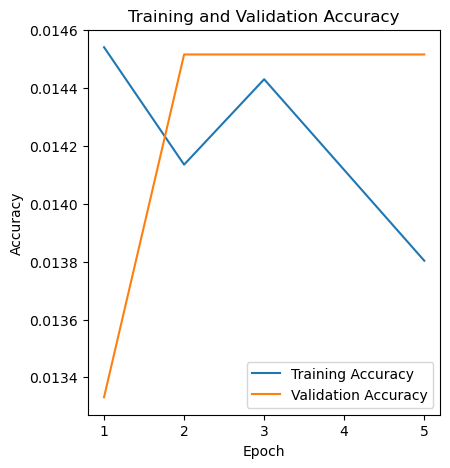

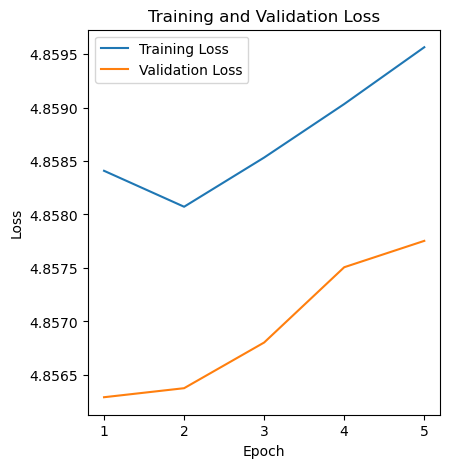

In [24]:
model_resnet = keras.models.load_model('../models/resnet50v2-1')

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(history.history['accuracy']) + 1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.title('Training and Validation Loss')